In [9]:
import tensorflow as tf
import os

In [10]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [11]:
# Remove dodgy images
import cv2
import imghdr
import matplotlib.pyplot as plt

data_dir = "data"

In [12]:
# Image extensions
image_exts = ['jpeg','jpg', 'bmp', 'png', 'gif']

# Exclude bad images
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [13]:
import numpy as np 
import matplotlib.pyplot as plt

data = tf.keras.utils.image_dataset_from_directory('data')

Found 1007 files belonging to 2 classes.


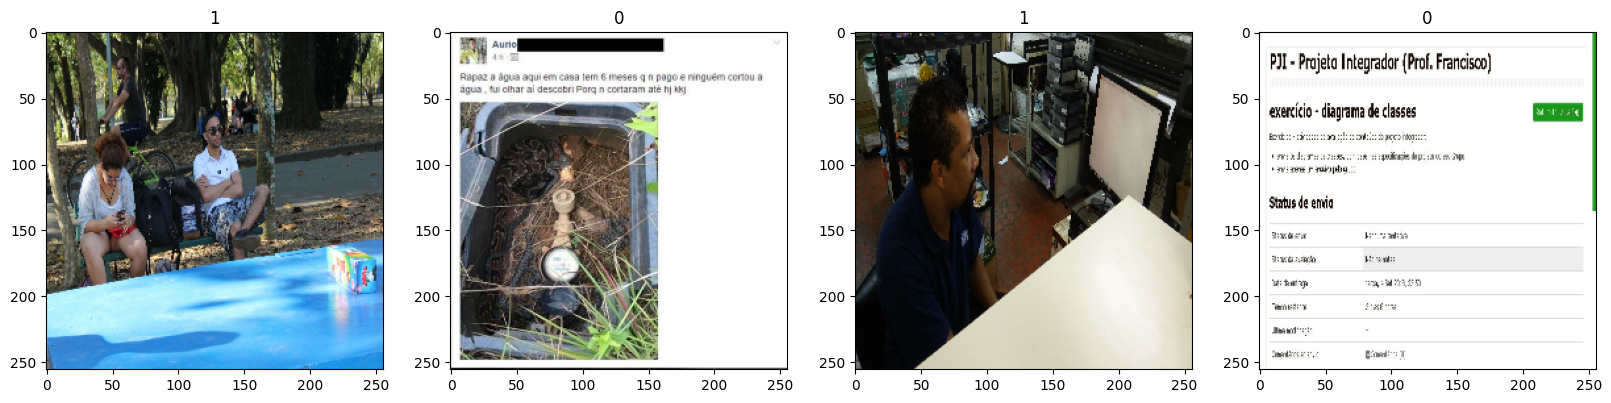

In [14]:
# Creat an iterator
data_iterator = data.as_numpy_iterator()

# Get another batch from the iterator
batch = data_iterator.next()

# Plot the images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])



## Preprocess Data :D 


In [15]:
# Normalize the pixels values
data = data.map(lambda x, y: (x / 255, y))

# Get the iterator 
scaled_iterator = data.as_numpy_iterator()

# Get a batch
batch = scaled_iterator.next()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


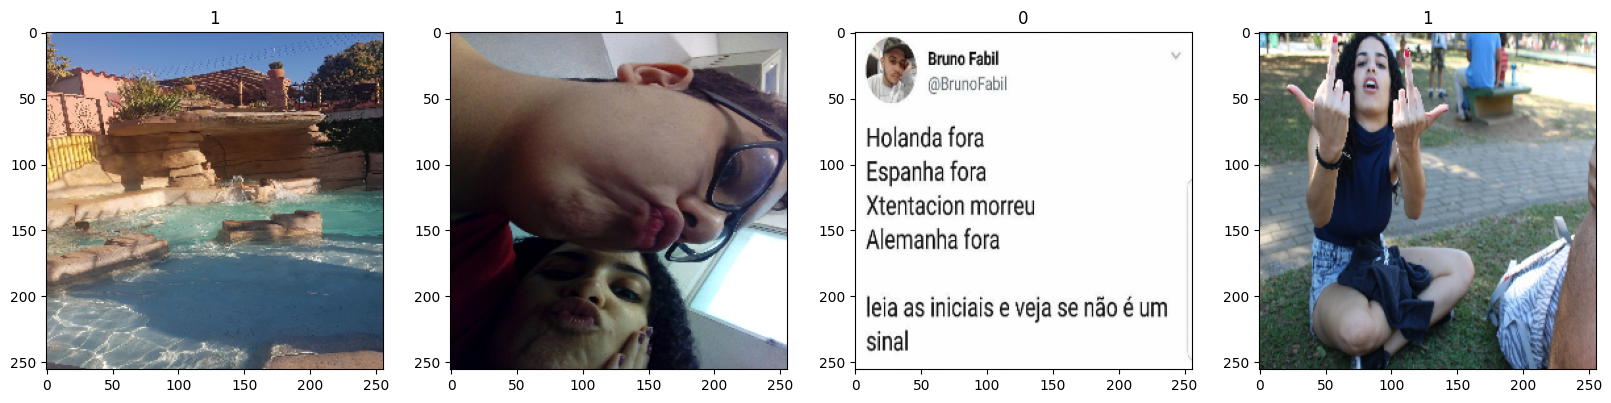

In [16]:
# Plot it
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [17]:
# Split the data
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1) + 1

# Get the data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)


## Deep Model


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [19]:
# Create the model :)

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [22]:
log_dir = "logs"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
22/22 [==============================] - 28s 1s/step - loss: 0.6758 - accuracy: 0.6463 - val_loss: 0.6042 - val_accuracy: 0.6339
Epoch 2/30
22/22 [==============================] - 26s 1s/step - loss: 0.5042 - accuracy: 0.7472 - val_loss: 0.4181 - val_accuracy: 0.7857
Epoch 3/30
22/22 [==============================] - 26s 1s/step - loss: 0.3915 - accuracy: 0.8054 - val_loss: 0.4125 - val_accuracy: 0.8125
Epoch 4/30
22/22 [==============================] - 26s 1s/step - loss: 0.3322 - accuracy: 0.8608 - val_loss: 0.3788 - val_accuracy: 0.8125
Epoch 5/30
22/22 [==============================] - 26s 1s/step - loss: 0.2438 - accuracy: 0.8807 - val_loss: 0.3293 - val_accuracy: 0.8348
Epoch 6/30
22/22 [==============================] - 26s 1s/step - loss: 0.1877 - accuracy: 0.9148 - val_loss: 0.2465 - val_accuracy: 0.9062
Epoch 7/30
22/22 [==============================] - 26s 1s/step - loss: 0.1237 - accuracy: 0.9560 - val_loss: 0.2943 - val_accuracy: 0.8750
Epoch 8/30
22/22 [==

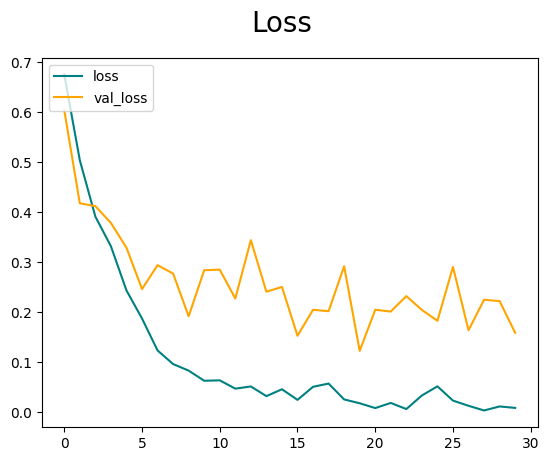

In [23]:
fig = plt.figure()

plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

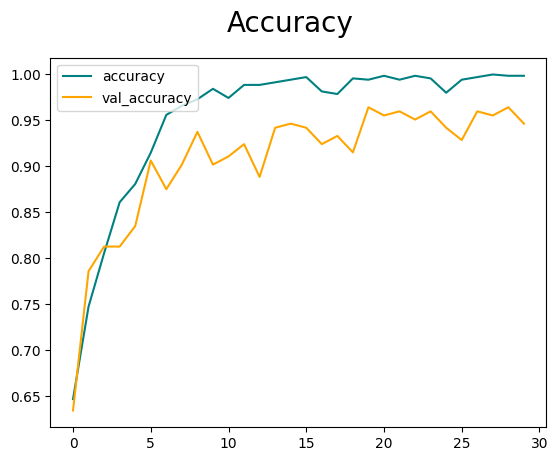

In [24]:
fig = plt.figure()

plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate Performance

In [25]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [26]:
# Instantiate the metrics
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [27]:
# Use the test data
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")


1/1 [==============================] - 0s 177ms/step
Precision: 0.949999988079071, Recall: 0.9743589758872986, Accuracy: 0.9620253443717957


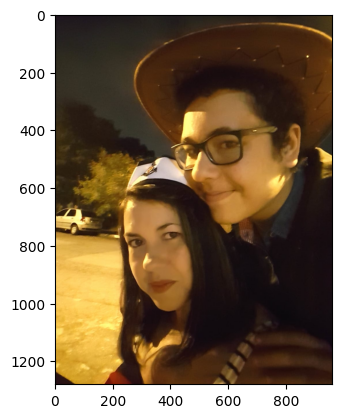

In [28]:
# Test the model
import cv2

img = cv2.imread("IMG-20180601-WA0018.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

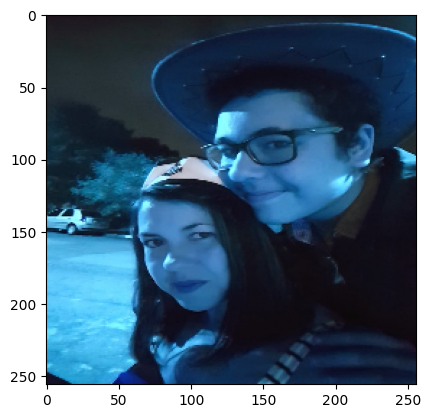

In [29]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))

In [30]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 33ms/step


array([[0.0019294]], dtype=float32)

In [31]:


if yhat > 0.5:
    print("This image is a memory")
else:
    print("This image is garbage")

This image is garbage


## Save this model


In [32]:
from tensorflow.keras.models import load_model

# Save it :)
model.save(os.path.join('models', 'happysadmodel.h5'))

In [33]:
# Load model :)
new_model = load_model(os.path.join('models', 'MemoryGarbageModel.h5'))

yhat = new_model.predict(np.expand_dims(resize/255, 0))

if yhat > 0.5:
    print("This image is a memory")
else:
    print("This image is a garbage")

1/1 [==============================] - 0s 107ms/step
This image is a memory
